# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
import cv2
import time
from sklearn.preprocessing import StandardScaler

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

C:\Users\prate\models\research\object_detection\utils\visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\prate\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\prate\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\prate\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\prate\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\prate\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

PATH_TO_TEST_IMAGES_DIR = 'D:\\video_project'
TEST_VIDEOS_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'video{}.mp4'.format(i)) for i in range(1, 76) ]
PATH_TO_TEST_VIDEO_DIR = [video.replace(".mp4","") for video in TEST_VIDEOS_PATHS]

In [ ]:
import pytube

datafile = open('D:\\video_project\Videos.csv', 'r', encoding="utf8")
#datafile = open('D:\PGYR16_P011718\sample.csv', 'r')
myreader = csv.reader(datafile)
next(myreader, None)
next(myreader, None)

for pos in myreader:
    #print(pos)
    link = "https://www.youtube.com/watch?v="+pos[0]
    yt = pytube.YouTube(link)
    stream = yt.streams.first()
    stream.download()

In [10]:
PATH_TO_TEST_IMAGES_DIR = 'D:\\video_project'
TEST_VIDEOS_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'video{}.mp4'.format(i)) for i in range(1, 76) ]
PATH_TO_TEST_VIDEO_DIR = [video.replace(".mp4","") for video in TEST_VIDEOS_PATHS]
print(PATH_TO_TEST_VIDEO_DIR)
j = 0
for video_path in TEST_VIDEOS_PATHS:
    print(video_path)
    v = cv2.VideoCapture(video_path)
    v.set(cv2.CAP_PROP_POS_AVI_RATIO,1)
    total = v.get(cv2.CAP_PROP_FPS) * v.get(cv2.CAP_PROP_POS_MSEC) / 1000
    print(total)
    gap = total / 10
    print(gap)
    desired_frames = np.arange(0,int(total),int(gap)) 
    count = 1
    os.mkdir(video_path.replace(".mp4",""))
    for i in desired_frames:
        v.set(1,i-1)                      
        success,image = v.read(1)         # image is an array of array of [R,G,B] values
        frameId = v.get(1)                # The 0th frame is often a throw-away
        cv2.imwrite(video_path.replace(".mp4","")+"/image%d.jpg" % count, image)
        count = count + 1

    v.release()
    print ("Complete") 
    j = j + 1

['D:\\video_project\\video1']
D:\video_project\video1.mp4
31440.0
3144.0
Complete


# Detection

In [9]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = ''
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 11) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [10]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [11]:
print(category_index)
count = 0
vid_dict = {}
for video_path in PATH_TO_TEST_VIDEO_DIR:
    vec = [0] * 90
    count = count + 1
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(video_path+"\\"+image_path.replace("D:\\video_project\\video1\\",""))
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)  
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      output_dict = run_inference_for_single_image(image_np, detection_graph)
      # Visualization of the results of a detection.
      #print(output_dict['detection_classes'])
      #print(output_dict['detection_scores'])  
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=8)
      #plt.figure(figsize=IMAGE_SIZE)
      #plt.imshow(image_np)
      for ele1,ele2 in zip(output_dict['detection_classes'],output_dict['detection_scores']):
          if ele2 > 0.5:
              print(category_index[ele1]["name"])
              vec[ele1-1] = vec[ele1-1] + 1
      vid_dict[count] = vec  
      #print(vec)
        
print(vid_dict)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

person
person
person
person
person
person
person
person
person
dog
person
person
cup
laptop
person
person
dog
cat
cat
person
car
car
tv
cat
{1: [9, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2: [5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3: [7, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 4: [7, 0, 3, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
import csv

datafile = open('D:\\video_project\Videos.csv', 'r', encoding="utf8")
#datafile = open('D:\PGYR16_P011718\sample.csv', 'r')
myreader = csv.reader(datafile)
next(myreader, None)
next(myreader, None)

cat_dict = []
viral_dict = []
meta_dict = []
for pos in myreader:
    #print(pos)
    meta_dict.append([int(pos[10]),int(pos[11]),int(pos[12])])
    cat_dict.append(int(pos[4]))
    viral_dict.append(int(pos[8]))
    
print(len(meta_dict))
print(cat_dict)
print(viral_dict)
            
feat = []
for i in range(1,76):
    #For objects as features
    feat.append(vid_dict[i])
    #For objects and metadata as features
    #feat.append(vid_dict[i]+meta_dict[i-1])
    
print(feat)
#print(cat_dict)

75
[2, 2, 2, 2, 2, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 2, 2, 2, 2, 2, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[[9, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19858, 147, 1707], [5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets

#Genre as label
train_features, test_features, train_labels, test_labels = train_test_split(feat, cat_dict, test_size = 0.25, random_state = 42)

#Virality as Label data
#train_features, test_features, train_labels, test_labels = train_test_split(feat, viral_dict, test_size = 0.25, random_state = 42)


In [20]:

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
clf0 = RandomForestClassifier(max_depth=2, random_state=0) 
# Train the model on training data
clf0.fit(train_features, train_labels)
print(clf0.feature_importances_)

from sklearn.naive_bayes import GaussianNB
clf1 = GaussianNB()
clf1.fit(train_features, train_labels)

from sklearn.svm import SVC
clf2 = SVC(probability=True)
clf2.fit(train_features, train_labels)


[ 0.00774783  0.          0.          0.          0.02211055  0.          0.
  0.          0.          0.          0.06715172  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.03396497  0.          0.          0.          0.
  0.04814815  0.          0.          0.          0.06787879  0.          0.
  0.          0.          0.          0.04291429  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.1         0.          0.00065844  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.03212121  0.          0.          0.05185185  0.          0.
  0.1676851

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
!pip install pydotplus
from sklearn.tree import export_graphviz
import pydotplus
import six
dotfile = six.StringIO()
i_tree = 0
for tree in clf0.estimators_:
    export_graphviz(tree, out_file=dotfile)
    pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png('dtree'+ str(i_tree) +'.png')
    i_tree = i_tree+1

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


InvocationException: GraphViz's executables not found

In [114]:

# Use the forest's predict method on the test data
predictions0 = clf0.predict(test_features)
#print(predictions)
proba0 = clf0.predict_proba(test_features)
#print(proba0)
score0 = []
for ele in proba0:
    score0.append(ele[1])
    
# Use the forest's predict method on the test data
predictions1 = clf1.predict(test_features)
#print(predictions)
proba1 = clf1.predict_proba(test_features)
#print(proba0)
score1 = []
for ele in proba1:
    score1.append(ele[1])    
    
    
# Use the forest's predict method on the test data
predictions2 = clf2.predict(test_features)
#print(predictions)
proba2 = clf2.predict_proba(test_features)
#print(proba0)
score2 = []
for ele in proba2:
    score2.append(ele[1])  

In [121]:

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(feat)

predictions = kmeans.predict(feat)

print(kmeans.cluster_centers_)
cluster_dict = {0:[0,0],1:[0,0],2:[0,0],3:[0,0],4:[0,0]}
for vi,pred in zip(viral_dict,predictions):
    count = count + 1
    if pred == 0:
        if vi == 1:
            cluster_dict[0][1] = cluster_dict[0][1] + 1
        else:
            cluster_dict[0][0] = cluster_dict[0][0] + 1
    elif pred == 1:
        if vi == 1:
            cluster_dict[1][1] = cluster_dict[1][1] + 1
        else:
            cluster_dict[1][0] = cluster_dict[1][0] + 1
    elif pred == 2:
        if vi == 1:
            cluster_dict[2][1] = cluster_dict[2][1] + 1
        else:
            cluster_dict[2][0] = cluster_dict[2][0] + 1
    elif pred == 3:
        if vi == 1:
            cluster_dict[3][1] = cluster_dict[3][1] + 1
        else:
            cluster_dict[3][0] = cluster_dict[3][0] + 1 
    elif pred == 4:
        if vi == 1:
            cluster_dict[4][1] = cluster_dict[4][1] + 1
        else:
            cluster_dict[4][0] = cluster_dict[4][0] + 1        
            
print(cluster_dict)

[[  6.33898305e+00   0.00000000e+00   1.38983051e+00   1.18644068e-01
    1.69491525e-01   3.38983051e-02   0.00000000e+00   1.52542373e-01
    1.69491525e-02   0.00000000e+00   1.73472348e-17   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   6.77966102e-02
    1.52542373e-01   7.62711864e-01   1.69491525e-02   1.01694915e-01
    3.38983051e-02   0.00000000e+00   6.77966102e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.86440678e-01   3.38983051e-02
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.69491525e-02
    1.69491525e-02   1.69491525e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.18644068e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.38983051e-02
    0.00000000e+00   0.00000000e+00   6.77966102e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.38983051e-02
    0.00000000e+00  

In [115]:
from sklearn.metrics import confusion_matrix

cnf_matrix0 = confusion_matrix(test_labels, predictions0)
cnf_matrix1= confusion_matrix(test_labels, predictions1)
cnf_matrix2 = confusion_matrix(test_labels, predictions2)

In [116]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[17  0]
 [ 2  0]]
Confusion matrix, without normalization
[[ 7 10]
 [ 0  2]]
Confusion matrix, without normalization
[[17  0]
 [ 2  0]]


<function matplotlib.pyplot.figure>

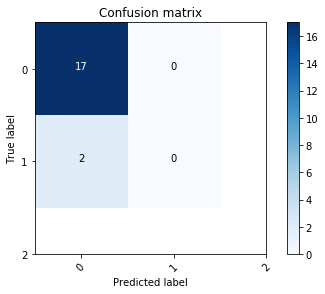

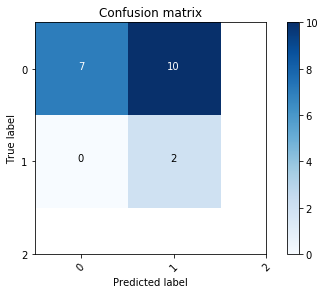

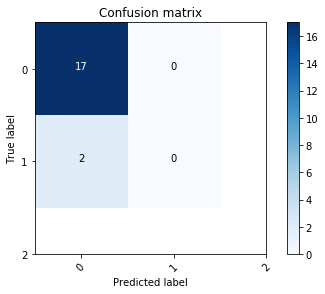

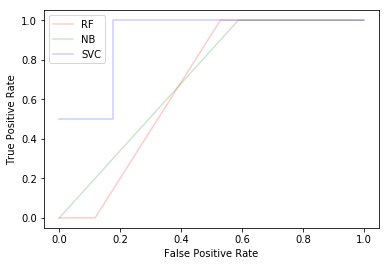

In [117]:
from sklearn.metrics import roc_curve
%matplotlib inline
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix0, classes = [0,1,2],title='Confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes = [0,1,2],title='Confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes = [0,1,2],title='Confusion matrix')
plt.figure()

fpr0, tpr0, thresholds0 = roc_curve(test_labels, score0)
plt.plot(fpr0,tpr0,color='r', alpha=0.2, label= 'RF')
fpr1, tpr1, thresholds1 = roc_curve(test_labels, score1)
plt.plot(fpr1,tpr1,color='g', alpha=0.2, label= 'NB')
fpr2, tpr2, thresholds2 = roc_curve(test_labels, score2)
plt.plot(fpr2,tpr2,color='b', alpha=0.2, label= 'SVC')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.figure